# Discriminative vs. Generative Modeling for Cardiovascular Risk Prediction 


### adding libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Loading dataset


In [4]:
# Step 1: Load the dataset
df = pd.read_csv("data/heart_disease_uci.csv")  # replace with your actual file path if needed

In [5]:
df

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,916,54,Female,VA Long Beach,asymptomatic,127.0,333.0,True,st-t abnormality,154.0,False,0.0,NaN,NaN,NaN,1
916,917,62,Male,VA Long Beach,typical angina,NaN,139.0,False,st-t abnormality,NaN,NaN,NaN,NaN,NaN,NaN,0
917,918,55,Male,VA Long Beach,asymptomatic,122.0,223.0,True,st-t abnormality,100.0,False,0.0,NaN,NaN,fixed defect,2
918,919,58,Male,VA Long Beach,asymptomatic,NaN,385.0,True,lv hypertrophy,NaN,NaN,NaN,NaN,NaN,NaN,0


# Task 1: Data Exploration & Gaussian Fitting

### • Handle missing or invalid values via deletion or imputation. 


In [6]:
# Step 2: Drop irrelevant columns
# df.drop(columns=["id", "dataset"], inplace=True)

# Step 3: Binarize target column
df["target"] = df["num"].apply(lambda x: 1 if x > 0 else 0)
# df.drop(columns=["num"], inplace=True)

# Step 4: Drop rows with any missing values
df.dropna(inplace=True)

# Step 5: Check remaining shape and confirm no missing values
print("Data shape after dropping missing values:", df.shape)
print("Remaining missing values:\n", df.isnull().sum())

Data shape after dropping missing values: (299, 17)
Remaining missing values:
 id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
target      0
dtype: int64


### • Plot distributions (histogram or KDE) of all features per class. 


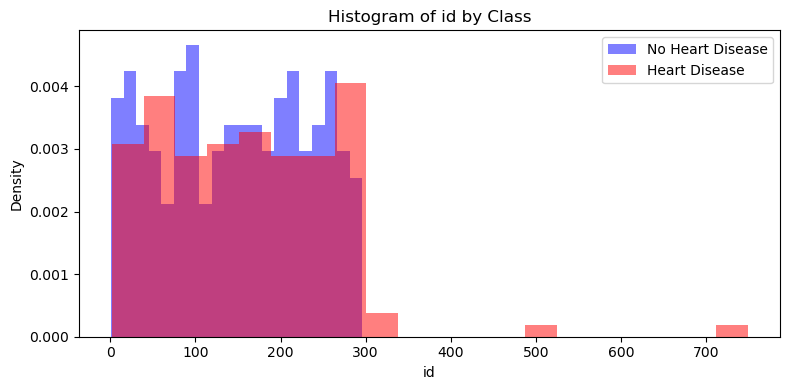

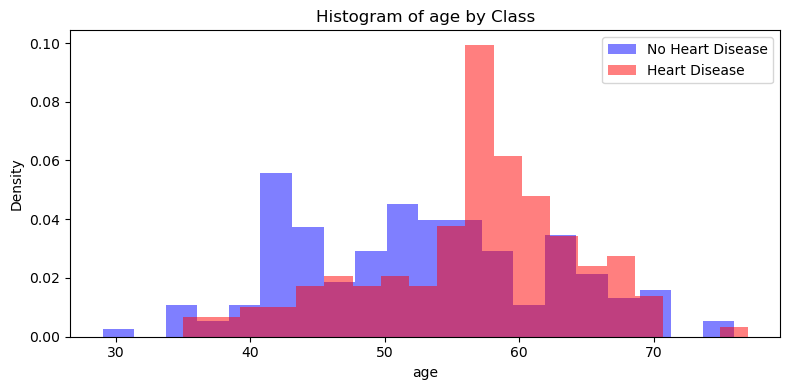

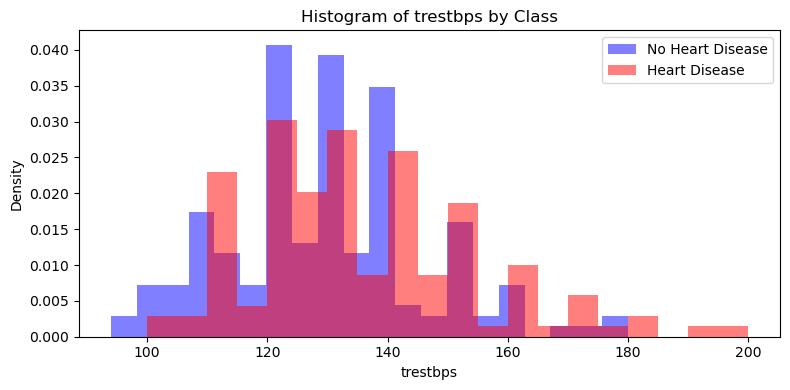

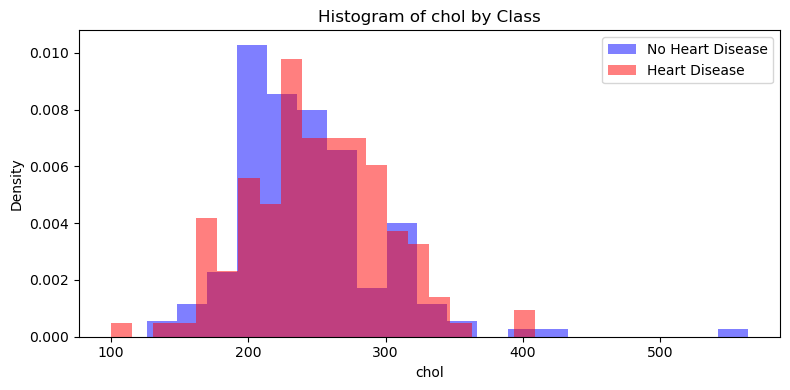

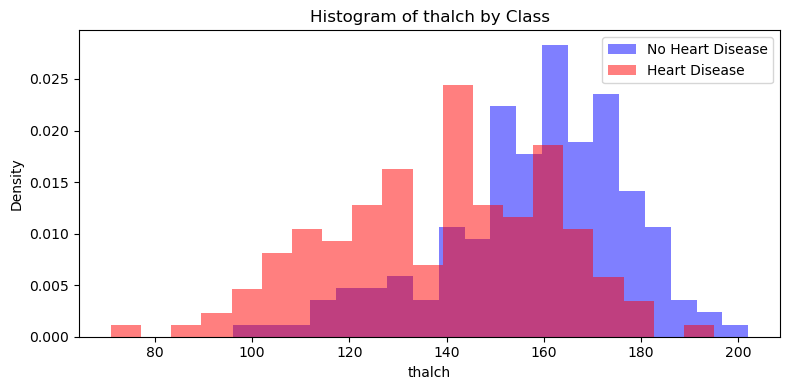

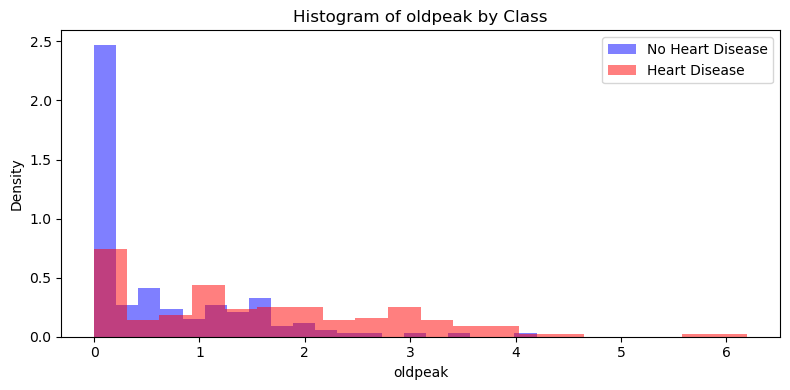

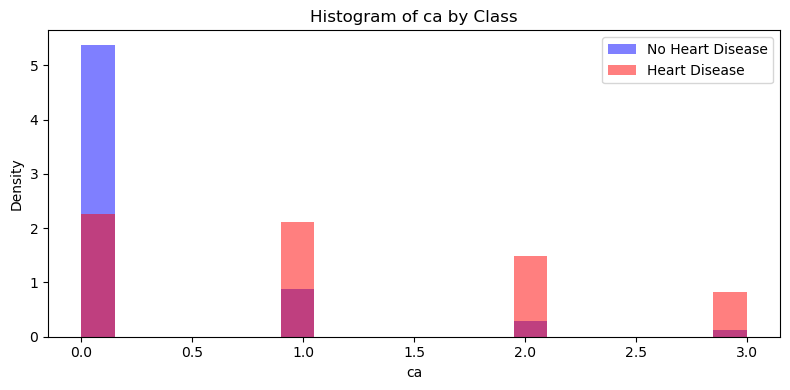

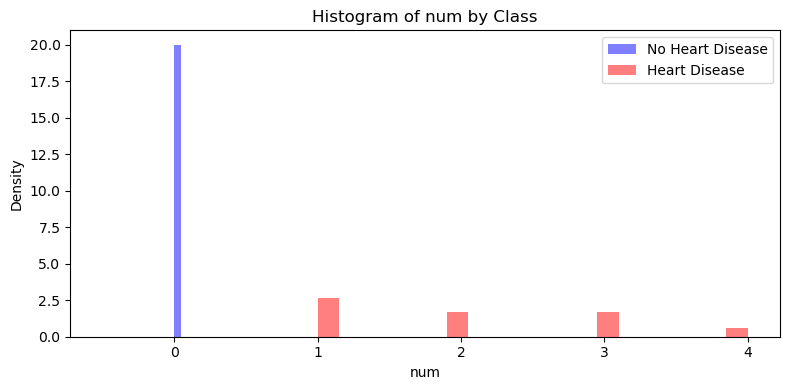

In [7]:
# Get list of numeric columns (excluding target)
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns.drop("target")

# Plot histogram for each numeric column, separated by class
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    plt.hist(df[df["target"] == 0][col], bins=20, alpha=0.5, label="No Heart Disease", color="blue", density=True)
    plt.hist(df[df["target"] == 1][col], bins=20, alpha=0.5, label="Heart Disease", color="red", density=True)
    plt.title(f"Histogram of {col} by Class")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()


### • Select two informative features (e.g., chol and thalach). 


In [8]:
# Select the two features: 'chol' and 'thalch'
selected_features = ["chol", "thalch", "target"]

# Extract subset
df_selected = df[selected_features]

# Display first few rows
print(df_selected.head())

    chol  thalch  target
0  233.0   150.0       0
1  286.0   108.0       1
2  229.0   129.0       1
3  250.0   187.0       0
4  204.0   172.0       0


### Fit 2D Gaussian distributions (one per class) and plot contour maps.

C:\Users\prca\AppData\Local\Temp\ipykernel_6724\802404007.py:33: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z0, levels=5, colors='blue', linestyles='dashed', label="No Heart Disease")
C:\Users\prca\AppData\Local\Temp\ipykernel_6724\802404007.py:34: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z1, levels=5, colors='red', linestyles='solid', label="Heart Disease")


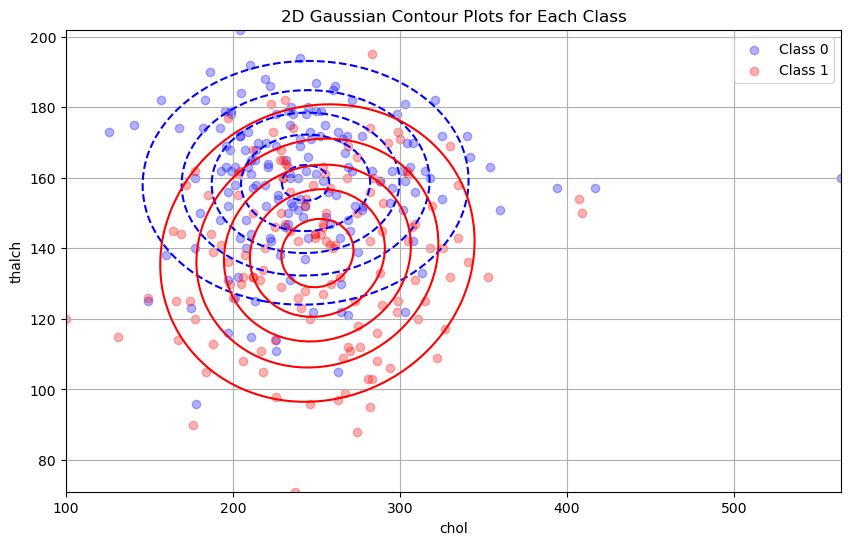

In [9]:
# Step 1: Extract data by class
X0 = df_selected[df_selected["target"] == 0][["chol", "thalch"]].values
X1 = df_selected[df_selected["target"] == 1][["chol", "thalch"]].values

# Step 2: Compute means and covariances
mu0 = np.mean(X0, axis=0)
mu1 = np.mean(X1, axis=0)
cov0 = np.cov(X0, rowvar=False)
cov1 = np.cov(X1, rowvar=False)

# Step 3: Create a mesh grid
x = np.linspace(df_selected["chol"].min(), df_selected["chol"].max(), 100)
y = np.linspace(df_selected["thalch"].min(), df_selected["thalch"].max(), 100)
X, Y = np.meshgrid(x, y)
grid = np.stack([X.ravel(), Y.ravel()], axis=1)

# Step 4: Multivariate Gaussian PDF function
def gaussian_pdf(x, mean, cov):
    d = mean.shape[0]
    det = np.linalg.det(cov)
    inv = np.linalg.inv(cov)
    norm_const = 1.0 / (np.power((2*np.pi), d/2) * np.sqrt(det))
    diff = x - mean
    result = norm_const * np.exp(-0.5 * np.sum(diff @ inv * diff, axis=1))
    return result

# Step 5: Evaluate PDF on grid
Z0 = gaussian_pdf(grid, mu0, cov0).reshape(X.shape)
Z1 = gaussian_pdf(grid, mu1, cov1).reshape(X.shape)

# Step 6: Plot
plt.figure(figsize=(10, 6))
plt.contour(X, Y, Z0, levels=5, colors='blue', linestyles='dashed', label="No Heart Disease")
plt.contour(X, Y, Z1, levels=5, colors='red', linestyles='solid', label="Heart Disease")
plt.scatter(X0[:, 0], X0[:, 1], color='blue', alpha=0.3, label="Class 0")
plt.scatter(X1[:, 0], X1[:, 1], color='red', alpha=0.3, label="Class 1")
plt.xlabel("chol")
plt.ylabel("thalch")
plt.title("2D Gaussian Contour Plots for Each Class")
plt.legend()
plt.grid(True)
plt.show()


### • Evaluate Gaussian assumption via plots and normality tests. 



📊 Evaluating Normality for: chol | Class 0


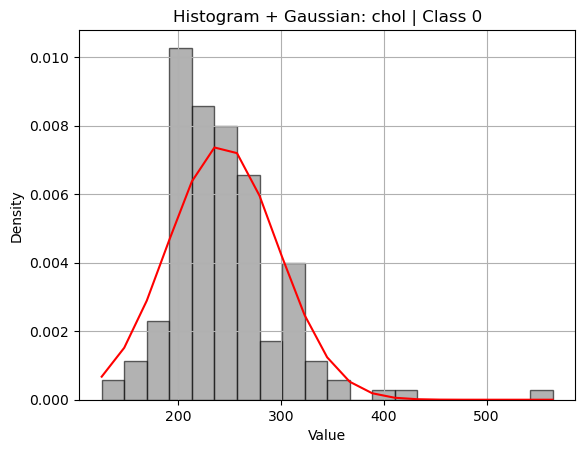

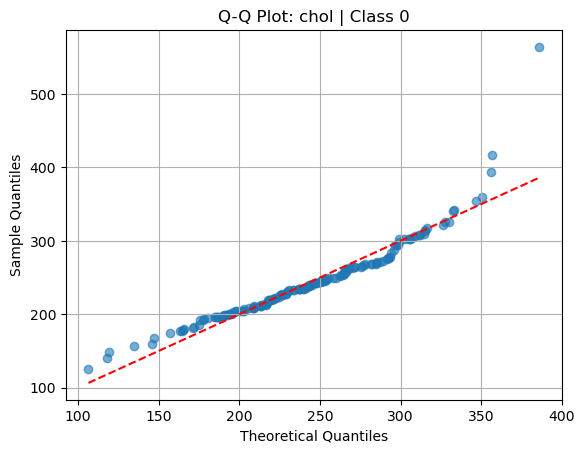


📊 Evaluating Normality for: chol | Class 1


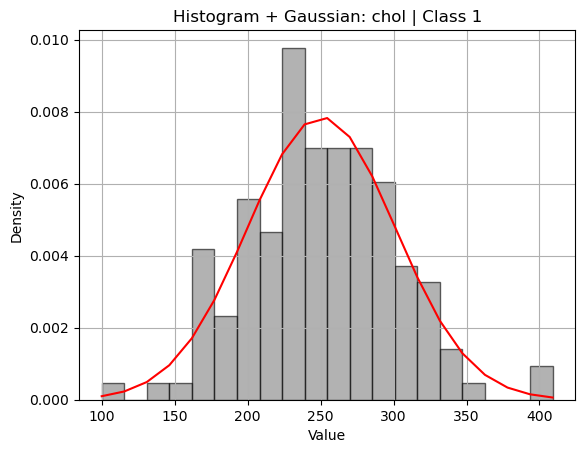

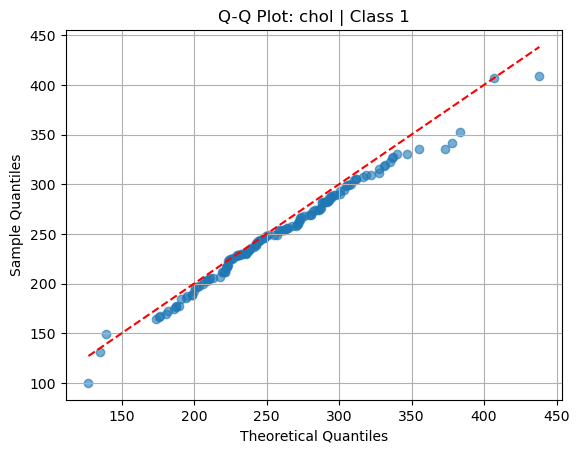


📊 Evaluating Normality for: thalch | Class 0


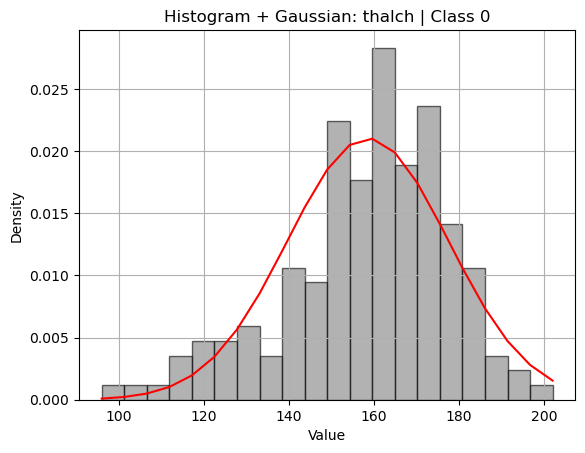

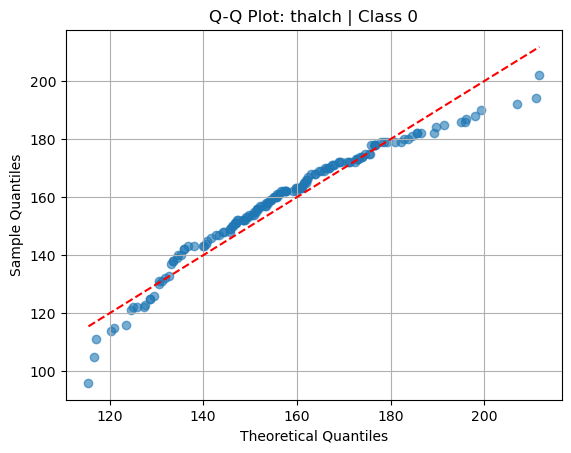


📊 Evaluating Normality for: thalch | Class 1


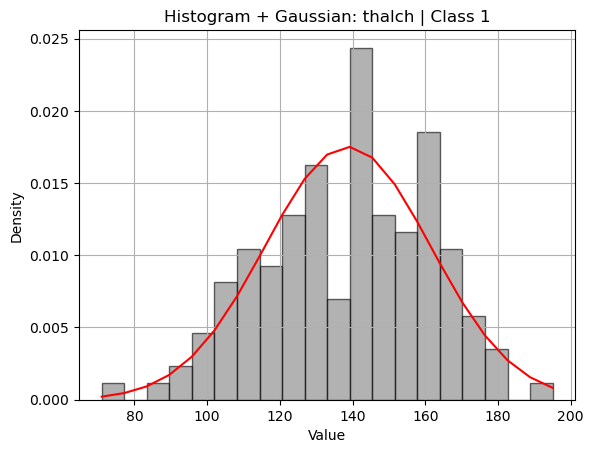

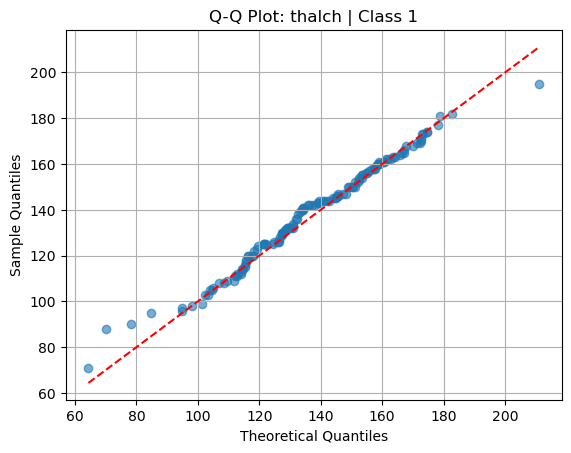

In [10]:

# Helper: Plot histograms with normal curve
def plot_hist_with_gaussian(data, title):
    mu = np.mean(data)
    sigma = np.std(data)

    count, bins, _ = plt.hist(data, bins=20, density=True, alpha=0.6, color='gray', edgecolor='black')
    gauss_curve = 1/(sigma * np.sqrt(2*np.pi)) * np.exp(-(bins - mu)**2 / (2*sigma**2))
    plt.plot(bins, gauss_curve, color='red')
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.grid(True)
    plt.show()

# Helper: Manual Q-Q plot
def qq_plot(data, title):
    sorted_data = np.sort(data)
    n = len(data)
    theoretical_q = np.sort(np.random.normal(np.mean(data), np.std(data), n))
    
    plt.scatter(theoretical_q, sorted_data, alpha=0.6)
    plt.plot(theoretical_q, theoretical_q, color='red', linestyle='--')
    plt.title("Q-Q Plot: " + title)
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.grid(True)
    plt.show()

# Analyze for each feature per class
for col in ["chol", "thalch"]:
    for label in [0, 1]:
        data = df_selected[df_selected["target"] == label][col].values
        title = f"{col} | Class {label}"

        print(f"\n📊 Evaluating Normality for: {title}")
        plot_hist_with_gaussian(data, f"Histogram + Gaussian: {title}")
        qq_plot(data, title)
